# Data Analysis Interview Challenge
## Ian Klasky

### Part 1 ‑ Exploratory data analysis

In cell 6 we can see the timeseries of logins per 15 minutes from the given dataset. In cell 8 we can see boxplots with the hourly login rates across all days in the data set. We can see clear usage patterns, with peak logins at both rush hours and around noon.

In [1]:
import os
import pandas as pd
import numpy as np
import seaborn as sns
import statsmodels.api as sm
import datetime as dt
from datetime import timedelta
import matplotlib.pyplot as plt
%matplotlib inline
import warnings
warnings.filterwarnings('ignore')

In [2]:
df = pd.read_json('logins.json')

df

,login_time
0,1970-01-01 20:13:18
1,1970-01-01 20:16:10
2,1970-01-01 20:16:37
3,1970-01-01 20:16:36
4,1970-01-01 20:26:21
...,...
93137,1970-04-13 18:50:19
93138,1970-04-13 18:43:56
93139,1970-04-13 18:54:02
93140,1970-04-13 18:57:38


In [3]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 93142 entries, 0 to 93141
Data columns (total 1 columns):
 #   Column      Non-Null Count  Dtype         
---  ------      --------------  -----         
 0   login_time  93142 non-null  datetime64[ns]
dtypes: datetime64[ns](1)
memory usage: 727.8 KB


In [4]:
if 'login_time' in df.columns:    
    df.index = pd.to_datetime(df.login_time, unit='s')
    df['counter'] = 1
    df.rename(columns={'login_time':'time'},inplace=True)
df

,time,counter
login_time,,
1970-01-01 20:13:18,1970-01-01 20:13:18,1
1970-01-01 20:16:10,1970-01-01 20:16:10,1
1970-01-01 20:16:37,1970-01-01 20:16:37,1
1970-01-01 20:16:36,1970-01-01 20:16:36,1
1970-01-01 20:26:21,1970-01-01 20:26:21,1
...,...,...
1970-04-13 18:50:19,1970-04-13 18:50:19,1
1970-04-13 18:43:56,1970-04-13 18:43:56,1
1970-04-13 18:54:02,1970-04-13 18:54:02,1


In [5]:
agg_15m = df.groupby(pd.Grouper(freq='15Min')).aggregate(np.sum)
agg_15m['time'] = agg_15m.index

agg_15m

,counter,time
login_time,,
1970-01-01 20:00:00,2,1970-01-01 20:00:00
1970-01-01 20:15:00,6,1970-01-01 20:15:00
1970-01-01 20:30:00,9,1970-01-01 20:30:00
1970-01-01 20:45:00,7,1970-01-01 20:45:00
1970-01-01 21:00:00,1,1970-01-01 21:00:00
...,...,...
1970-04-13 17:45:00,5,1970-04-13 17:45:00
1970-04-13 18:00:00,5,1970-04-13 18:00:00
1970-04-13 18:15:00,2,1970-04-13 18:15:00


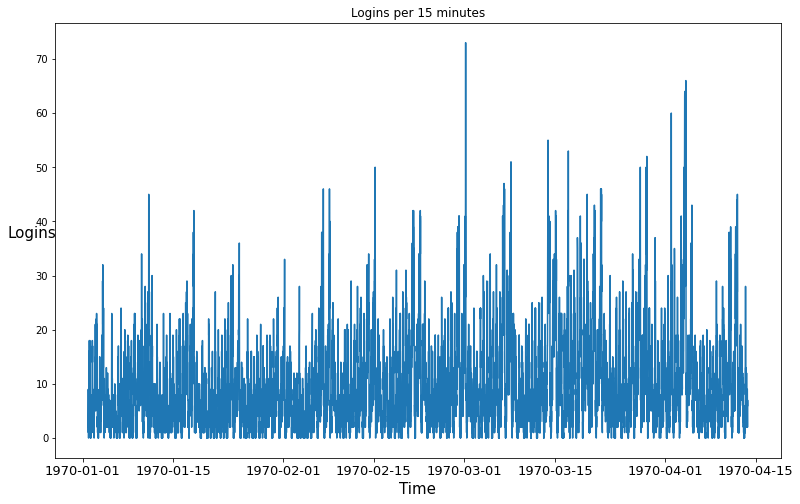

In [6]:
plt.figure(figsize=(13, 8))
plt.plot(agg_15m.time,agg_15m.counter)

plt.title('Logins per 15 minutes')
plt.ylabel('Logins',rotation=0,size=15)
plt.xlabel('Time',rotation=0,size=15)
plt.tick_params(axis='x', which='major', labelsize=13)
plt.show()

In [7]:
agg_hour = df.groupby(pd.Grouper(freq='60Min')).aggregate(np.sum)
agg_hour['time'] = agg_hour.index
agg_hour['hour'] = agg_hour.time.dt.hour
agg_hour

,counter,time,hour
login_time,,,
1970-01-01 20:00:00,24,1970-01-01 20:00:00,20
1970-01-01 21:00:00,9,1970-01-01 21:00:00,21
1970-01-01 22:00:00,21,1970-01-01 22:00:00,22
1970-01-01 23:00:00,58,1970-01-01 23:00:00,23
1970-01-02 00:00:00,53,1970-01-02 00:00:00,0
...,...,...,...
1970-04-13 14:00:00,32,1970-04-13 14:00:00,14
1970-04-13 15:00:00,19,1970-04-13 15:00:00,15
1970-04-13 16:00:00,22,1970-04-13 16:00:00,16


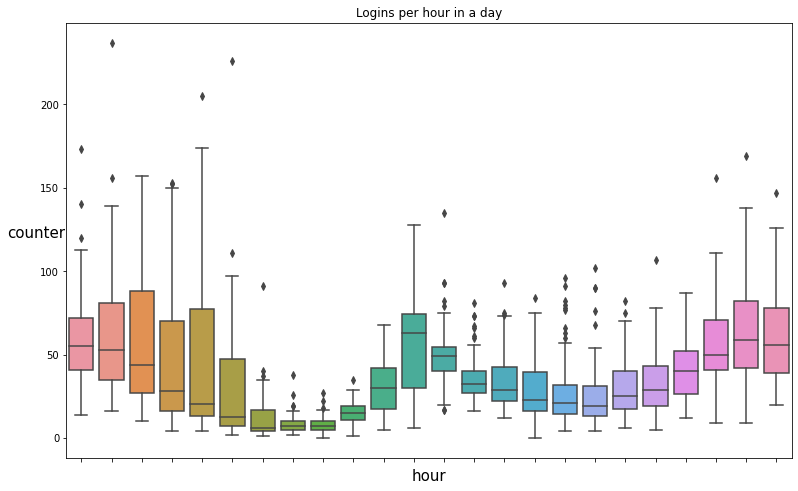

In [8]:
plt.figure(figsize=(13, 8))
plt.title('Logins per hour in a day')
plt.ylabel('Logins',rotation=0,size=15)
plt.xlabel('Hour',rotation=0,size=15)
plt.tick_params(axis='x', which='major', labelsize=13)

sns.boxplot(data=agg_hour,y="counter",x="hour",orient="v").set(xticklabels=[])
plt.show()

### Part 2 ‑ Experiment and metrics design

Metrics could be average driver revenue per hour (adjusted for additional toll cost). You could design an A/B test where one group of drivers are given toll reimbursement and the rest of the drivers are not. You would then use a t-test to determine if the difference between the two groups average revenue is statistically significant to a given confidence level.

### Part 3 ‑ Predictive modeling

In this section I implemented binary classification models to predict wether or not a user was active in the 6th month of available data given all other features. We will begin this process by performing some EDA on our given dataset.

In cell 10 I engineered our target feature "active" using the "last_trip_date" feature. In cell 11 we can see the somewhat unbalanced distribution of drivers who were active in the 6th month. Approximately 38% of the drivers in this sample were active in the 6th month.

In cell 14 I generated a heatmap of the feature correlations to see if there were any highly correlated features, or target leakage. I found no target leakage, and no exceedingly highly correlations between the features. I then proceeded to train test split my dataset and run the models.

I evaluated the models based on their AUC / ROC score instead of accuracy, because accuracy of over 50% could be achieved by saying all drivers are inactive. AUC / ROC gives more insight as to how well the model is able to differentiate between the two classes of drivers.

Of the three models I used - logistic regression, random forest & xgboost, random forest and xgboost had a higher AUC / ROC score than logistic regression. Random forest had a significantly higher sensitivity (true positive rate) than xgboost, so we will designate the former as our best predictive model.

In cell 28 we can see the features most important to the random forest models classification of driver status, are average driver rating, and the percentage of drivers trips that occurred on the weekday. We might then say that incentivizing the drivers to achive higher ratings or drive on the weekday or weekend could improve these metrics and might lead to an increase in driver retention.

In [9]:
df2 = pd.read_json('ultimate_data_challenge.json')
df2

,city,trips_in_first_30_days,signup_date,avg_rating_of_driver,avg_surge,last_trip_date,phone,surge_pct,ultimate_black_user,weekday_pct,avg_dist,avg_rating_by_driver
0,King's Landing,4,2014-01-25,4.7,1.10,2014-06-17,iPhone,15.4,True,46.2,3.67,5.0
1,Astapor,0,2014-01-29,5.0,1.00,2014-05-05,Android,0.0,False,50.0,8.26,5.0
2,Astapor,3,2014-01-06,4.3,1.00,2014-01-07,iPhone,0.0,False,100.0,0.77,5.0
3,King's Landing,9,2014-01-10,4.6,1.14,2014-06-29,iPhone,20.0,True,80.0,2.36,4.9
4,Winterfell,14,2014-01-27,4.4,1.19,2014-03-15,Android,11.8,False,82.4,3.13,4.9
...,...,...,...,...,...,...,...,...,...,...,...,...
49995,King's Landing,0,2014-01-25,5.0,1.00,2014-06-05,iPhone,0.0,False,100.0,5.63,4.2
49996,Astapor,1,2014-01-24,NaN,1.00,2014-01-25,iPhone,0.0,False,0.0,0.00,4.0
49997,Winterfell,0,2014-01-31,5.0,1.00,2014-05-22,Android,0.0,True,100.0,3.86,5.0
49998,Astapor,2,2014-01-14,3.0,1.00,2014-01-15,iPhone,0.0,False,100.0,4.58,3.5


In [10]:
if 'signup_date' and 'last_trip_date'in df2.columns:

    df2['last_trip_date_2'] = pd.to_datetime(df2['last_trip_date'], format='%Y-%m-%d')
    df2['active'] = (df2.last_trip_date_2 >= dt.datetime.strptime('2014-06-01', '%Y-%m-%d')).astype('int')

    df2['signup_date_2'] = pd.to_datetime(df2['signup_date'], format='%Y-%m-%d')
    df2['signup_date_int'] = abs((df2.signup_date_2 - dt.datetime.strptime('2014-06-01', '%Y-%m-%d'))).astype('timedelta64[D]')

    df2.drop(['signup_date','last_trip_date','signup_date_2','last_trip_date_2'],axis=1,inplace=True)

df2

,city,trips_in_first_30_days,avg_rating_of_driver,avg_surge,phone,surge_pct,ultimate_black_user,weekday_pct,avg_dist,avg_rating_by_driver,active,signup_date_int
0,King's Landing,4,4.7,1.10,iPhone,15.4,True,46.2,3.67,5.0,1,127.0
1,Astapor,0,5.0,1.00,Android,0.0,False,50.0,8.26,5.0,0,123.0
2,Astapor,3,4.3,1.00,iPhone,0.0,False,100.0,0.77,5.0,0,146.0
3,King's Landing,9,4.6,1.14,iPhone,20.0,True,80.0,2.36,4.9,1,142.0
4,Winterfell,14,4.4,1.19,Android,11.8,False,82.4,3.13,4.9,0,125.0
...,...,...,...,...,...,...,...,...,...,...,...,...
49995,King's Landing,0,5.0,1.00,iPhone,0.0,False,100.0,5.63,4.2,1,127.0
49996,Astapor,1,NaN,1.00,iPhone,0.0,False,0.0,0.00,4.0,0,128.0
49997,Winterfell,0,5.0,1.00,Android,0.0,True,100.0,3.86,5.0,0,121.0
49998,Astapor,2,3.0,1.00,iPhone,0.0,False,100.0,4.58,3.5,0,138.0


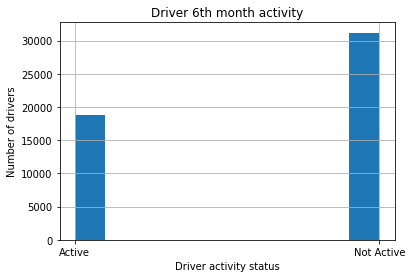

0.37608

In [11]:
df2.active.replace({0: 'Not Active', 1: 'Active'}).hist()
plt.title("Driver 6th month activity")
plt.xlabel("Driver activity status")
plt.ylabel("Number of drivers")
plt.show()

df2.active.sum()/df2.shape[0]

In [12]:
df2.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 50000 entries, 0 to 49999
Data columns (total 12 columns):
 #   Column                  Non-Null Count  Dtype  
---  ------                  --------------  -----  
 0   city                    50000 non-null  object 
 1   trips_in_first_30_days  50000 non-null  int64  
 2   avg_rating_of_driver    41878 non-null  float64
 3   avg_surge               50000 non-null  float64
 4   phone                   49604 non-null  object 
 5   surge_pct               50000 non-null  float64
 6   ultimate_black_user     50000 non-null  bool   
 7   weekday_pct             50000 non-null  float64
 8   avg_dist                50000 non-null  float64
 9   avg_rating_by_driver    49799 non-null  float64
 10  active                  50000 non-null  int64  
 11  signup_date_int         50000 non-null  float64
dtypes: bool(1), float64(7), int64(2), object(2)
memory usage: 4.2+ MB


In [13]:
impute_cols = ['avg_rating_of_driver','phone','avg_rating_by_driver']
if 'iPhone' in list(df2.phone.unique()):
    df2.phone.replace({'iPhone':1,'Android':2},inplace=True)
# if type(df2.last_trip_date) == 'O':
#     df2['last_trip_date_num'] = abs((df2.last_trip_date - d1).days)

for col in impute_cols:
    df2[col] = df2[col].fillna((df2[col].median()))
df2.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 50000 entries, 0 to 49999
Data columns (total 12 columns):
 #   Column                  Non-Null Count  Dtype  
---  ------                  --------------  -----  
 0   city                    50000 non-null  object 
 1   trips_in_first_30_days  50000 non-null  int64  
 2   avg_rating_of_driver    50000 non-null  float64
 3   avg_surge               50000 non-null  float64
 4   phone                   50000 non-null  float64
 5   surge_pct               50000 non-null  float64
 6   ultimate_black_user     50000 non-null  bool   
 7   weekday_pct             50000 non-null  float64
 8   avg_dist                50000 non-null  float64
 9   avg_rating_by_driver    50000 non-null  float64
 10  active                  50000 non-null  int64  
 11  signup_date_int         50000 non-null  float64
dtypes: bool(1), float64(8), int64(2), object(1)
memory usage: 4.2+ MB


In [14]:
df2.corr().style.background_gradient(cmap='coolwarm')

,trips_in_first_30_days,avg_rating_of_driver,avg_surge,phone,surge_pct,ultimate_black_user,weekday_pct,avg_dist,avg_rating_by_driver,active,signup_date_int
trips_in_first_30_days,1.000000,-0.048272,-0.001841,-0.059309,0.005720,0.112210,0.050388,-0.136329,-0.039988,0.210463,-0.012351
avg_rating_of_driver,-0.048272,1.000000,-0.019948,0.033889,-0.004502,-0.008891,0.008095,0.053208,0.101203,-0.041082,-0.009508
avg_surge,-0.001841,-0.019948,1.000000,-0.008977,0.793582,-0.078791,-0.110071,-0.081491,0.011311,-0.003333,0.006944
phone,-0.059309,0.033889,-0.008977,1.000000,-0.010150,-0.075836,-0.009241,0.020888,0.008795,-0.225464,-0.014516
surge_pct,0.005720,-0.004502,0.793582,-0.010150,1.000000,-0.106861,-0.144918,-0.104414,0.020646,0.011797,-0.001667
ultimate_black_user,0.112210,-0.008891,-0.078791,-0.075836,-0.106861,1.000000,0.035998,0.032310,0.008466,0.205002,0.007398
weekday_pct,0.050388,0.008095,-0.110071,-0.009241,-0.144918,0.035998,1.000000,0.101652,0.019941,0.009693,-0.007367
avg_dist,-0.136329,0.053208,-0.081491,0.020888,-0.104414,0.032310,0.101652,1.000000,0.079883,-0.092780,-0.017274
avg_rating_by_driver,-0.039988,0.101203,0.011311,0.008795,0.020646,0.008466,0.019941,0.079883,1.000000,-0.027548,-0.002520
active,0.210463,-0.041082,-0.003333,-0.225464,0.011797,0.205002,0.009693,-0.092780,-0.027548,1.000000,0.020211


In [15]:
X = df2.drop('active',axis=1)
y = df2.active

#Dummy variables
dummy_list = []
for col in X.columns:
    if df2[col].dtype != 'float64' and df2[col].dtype != 'int64':
        dummy_list.append(col)
X = pd.get_dummies(X, prefix=dummy_list, columns=dummy_list)

In [16]:
X

,trips_in_first_30_days,avg_rating_of_driver,avg_surge,phone,surge_pct,weekday_pct,avg_dist,avg_rating_by_driver,signup_date_int,city_Astapor,city_King's Landing,city_Winterfell,ultimate_black_user_False,ultimate_black_user_True
0,4,4.7,1.10,1.0,15.4,46.2,3.67,5.0,127.0,0,1,0,0,1
1,0,5.0,1.00,2.0,0.0,50.0,8.26,5.0,123.0,1,0,0,1,0
2,3,4.3,1.00,1.0,0.0,100.0,0.77,5.0,146.0,1,0,0,1,0
3,9,4.6,1.14,1.0,20.0,80.0,2.36,4.9,142.0,0,1,0,0,1
4,14,4.4,1.19,2.0,11.8,82.4,3.13,4.9,125.0,0,0,1,1,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
49995,0,5.0,1.00,1.0,0.0,100.0,5.63,4.2,127.0,0,1,0,1,0
49996,1,4.9,1.00,1.0,0.0,0.0,0.00,4.0,128.0,1,0,0,1,0
49997,0,5.0,1.00,2.0,0.0,100.0,3.86,5.0,121.0,0,0,1,0,1
49998,2,3.0,1.00,1.0,0.0,100.0,4.58,3.5,138.0,1,0,0,1,0


In [17]:
def selected_metrics(conf_mat):
    
    sensitivity = round(conf_mat.pred_pos[1]/(conf_mat.pred_neg[1]+conf_mat.pred_pos[1]),4)
    specificity = round(conf_mat.pred_neg[0]/(conf_mat.pred_neg[0]+conf_mat.pred_pos[0]),4)
    accuracy = round((conf_mat.pred_pos.loc['pos'] + conf_mat.pred_neg.loc['neg']) / conf_mat.sum().sum(),4)
    f1_score = round(2 * (sensitivity*specificity)/(sensitivity+specificity),4)
    
    
    print('\nSensitivity: ', sensitivity)
    print('Specificity: ', specificity)
    print('Accuracy: ', accuracy)
    print('F1 score: ', f1_score)
    
    return

In [18]:
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state = 42)

In [19]:
from sklearn.linear_model import LogisticRegression
from sklearn import metrics
logreg = LogisticRegression(class_weight = 'balanced',random_state=42)
logreg.fit(X_train, y_train)

LogisticRegression(class_weight='balanced', random_state=42)

In [20]:
y_pred_lr = logreg.predict(X_test)

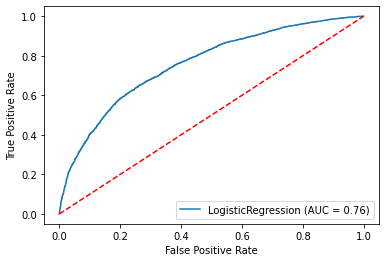

In [21]:
import sklearn.metrics as metrics
from sklearn.metrics import roc_auc_score
from sklearn.metrics import roc_curve
from sklearn.metrics import auc
from sklearn.metrics import plot_roc_curve
from sklearn.metrics import precision_recall_curve, confusion_matrix


plot_roc_curve(logreg, X_test, y_test)
plt.plot([0, 1], [0, 1],'r--')
plt.show()

In [22]:
conf_mat_lr = pd.DataFrame(confusion_matrix(y_test, y_pred_lr),columns=['pred_neg', 'pred_pos'], index=['neg', 'pos'])
selected_metrics(conf_mat_lr)


Sensitivity:  0.666
Specificity:  0.7184
Accuracy:  0.6986
F1 score:  0.6912


In [23]:
pd.DataFrame(abs(logreg.coef_).T, X.columns, columns=['Coefficient']).sort_values(by=['Coefficient'],ascending=False).head(10)

,Coefficient
phone,1.019047
city_King's Landing,0.983491
city_Astapor,0.730935
ultimate_black_user_True,0.438233
ultimate_black_user_False,0.416231
city_Winterfell,0.230554
trips_in_first_30_days,0.133937
avg_rating_of_driver,0.072522
avg_rating_by_driver,0.048034
avg_dist,0.035341


In [24]:
from sklearn.metrics import make_scorer, recall_score, accuracy_score, precision_score
from sklearn.model_selection import GridSearchCV, StratifiedKFold
from sklearn.ensemble import RandomForestClassifier

clf = RandomForestClassifier(class_weight = 'balanced',random_state = 42)

param_grid = {
    'n_estimators' : [100,200,300],
    'max_depth': [3,10,15]
}

scorers = {
    'precision_score': make_scorer(precision_score),
    'recall_score': make_scorer(recall_score),
    'accuracy_score': make_scorer(accuracy_score),
    'roc_auc_score': make_scorer(roc_auc_score)
}

In [25]:
def grid_search_wrapper(refit_score='roc_auc_score'):
    """
    fits a GridSearchCV classifier using refit_score for optimization
    prints classifier performance metrics
    """
    grid_search = GridSearchCV(clf, param_grid, scoring=scorers, refit=refit_score,
                           cv=3, return_train_score=True, n_jobs=-1)
    grid_search.fit(X_train, y_train)

    # make the predictions
    y_pred2 = grid_search.predict(X_test.values)

    print('Best params for {}'.format(refit_score))
    print(grid_search.best_params_)

    # confusion matrix on the test data.
    print('\nConfusion matrix of Random Forest optimized\nfor {} on the test data:'.format(refit_score))
    conf_mat_rf = pd.DataFrame(confusion_matrix(y_test, y_pred2),columns=['pred_neg', 'pred_pos'], index=['neg', 'pos'])
    print(conf_mat_rf)
    selected_metrics(conf_mat_rf)
    
    return grid_search, y_pred2

In [26]:
grid_search_clf,y_pred_rf = grid_search_wrapper(refit_score='roc_auc_score')

Best params for roc_auc_score
{'max_depth': 10, 'n_estimators': 100}

Confusion matrix of Random Forest optimized
for roc_auc_score on the test data:
     pred_neg  pred_pos
neg      4995      1224
pos       977      2804

Sensitivity:  0.7416
Specificity:  0.8032
Accuracy:  0.7799
F1 score:  0.7712


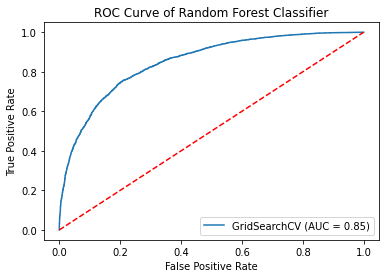

In [27]:
from sklearn.metrics import plot_roc_curve
plot_roc_curve(grid_search_clf, X_test, y_test)
plt.plot([0, 1], [0, 1],'r--')
plt.title('ROC Curve of Random Forest Classifier')
plt.show()

In [28]:
pd.DataFrame(grid_search_clf.best_estimator_.feature_importances_.T, X.columns, columns=['Coefficient']).sort_values(by=['Coefficient'],ascending=False).head(10)

,Coefficient
avg_rating_by_driver,0.177326
weekday_pct,0.137927
city_King's Landing,0.110924
surge_pct,0.103345
avg_surge,0.076661
phone,0.073707
trips_in_first_30_days,0.070989
avg_dist,0.053536
ultimate_black_user_False,0.036785
avg_rating_of_driver,0.036250


In [29]:
from xgboost import XGBClassifier
from sklearn.metrics import accuracy_score

In [30]:
xgboost = XGBClassifier(class_weight = 'balanced',random_state=42)
params = {
        'min_child_weight': [1, 5, 10],
        'gamma': [0.5, 1, 1.5, 2, 5],
        'subsample': [0.6, 0.8, 1.0],
        'colsample_bytree': [0.6, 0.8, 1.0],
        'max_depth': [3, 4, 5]
        }
xgboost.fit(X_train, y_train)

[02:23:58] WARNING: /Users/travis/build/dmlc/xgboost/src/learner.cc:480: 
Parameters: { class_weight } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.




XGBClassifier(base_score=0.5, booster='gbtree', class_weight='balanced',
              colsample_bylevel=1, colsample_bynode=1, colsample_bytree=1,
              gamma=0, gpu_id=-1, importance_type='gain',
              interaction_constraints='', learning_rate=0.300000012,
              max_delta_step=0, max_depth=6, min_child_weight=1, missing=nan,
              monotone_constraints='()', n_estimators=100, n_jobs=0,
              num_parallel_tree=1, random_state=42, reg_alpha=0, reg_lambda=1,
              scale_pos_weight=1, subsample=1, tree_method='exact',
              validate_parameters=1, verbosity=None)

In [31]:
y_pred_xgb = xgboost.predict(X_test)
predictions = [round(value) for value in y_pred_xgb]

In [32]:
conf_mat_xgb = pd.DataFrame(confusion_matrix(y_test, y_pred_xgb),columns=['pred_neg', 'pred_pos'], index=['neg', 'pos'])
selected_metrics(conf_mat_xgb)


Sensitivity:  0.6771
Specificity:  0.8497
Accuracy:  0.7844
F1 score:  0.7536


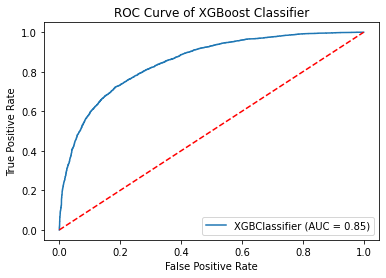

In [33]:
plot_roc_curve(xgboost, X_test, y_test)
plt.plot([0, 1], [0, 1],'r--')
plt.title('ROC Curve of XGBoost Classifier')
plt.show()

In [34]:
feature_importances_xgb = pd.DataFrame(xgboost.feature_importances_,
                                   index = X_train.columns,
                                   columns=['importance']).sort_values('importance',ascending=False)
feature_importances_xgb

,importance
city_King's Landing,0.323338
avg_rating_by_driver,0.158767
phone,0.122407
ultimate_black_user_False,0.096099
surge_pct,0.073009
city_Astapor,0.059064
weekday_pct,0.046082
trips_in_first_30_days,0.032323
avg_surge,0.022161
avg_rating_of_driver,0.021414
